In [1]:
"""Imports and constants"""

import os
import pandas as pd
import seaborn as sns

SEED = 42

In [2]:
"""Functions"""

def read_solution_file(name, root):
    """Read solution csv to pandas dataframe"""
    dataset, n, *_ = name.split('_')
    columns = [('index', ''), ('n', ''), ('value', '')]
    columns.extend([('item', i) for i in range(int(n))])
    columns.append(('trailing', ''))
    data = pd.read_csv(os.path.join(root, name), sep=' ', header=None, names=columns)
    data.insert(0, ('dataset', ''), dataset)
    data.insert(0, ('source', ''), root.split('/')[-1])
    data.columns = pd.MultiIndex.from_tuples(data.columns)
    return data

def read_metadata_file(name, root):
    """Read metadata csv to pandas dataframe"""
    
    data = pd.read_csv(os.path.join(root, name), sep=' ', header=None)

    # Rename columns at the beginning [('idx', ''), ('n', ''),...]
    first_cols = {
        data.columns[0]: ('index',''),
        data.columns[1]: ('n',''),
    }
    # Rename columns at the end [..., ('total_eval',''), ('seconds', '')]
    last_cols = {
        data.columns[-2]: ('total_eval',''),
        data.columns[-1]: ('seconds',''),
    }
    # Rename steps [k,k+1,...,k+n] -> [('step', 0), ('step',1), ..., ('step',n)]
    step_cols = {n: ('step', i) for i, n in enumerate(data.columns[len(first_cols) : -len(last_cols)])}

    # Renaming itself
    data = data.rename({**first_cols, **step_cols, **last_cols}, axis=1)
    
    # Insert source and dataset columns at the beginning
    data.insert(0, ('dataset',''), name.split('_')[0])
    data.insert(0, ('source', ''), root.split('/')[-1])

    # Make columns multiindex
    data.columns = pd.MultiIndex.from_tuples(data.columns)

    return data

def calculate_rel_error(optimal_value, computed_value):
    """Calculate relative error"""
    difference = abs(optimal_value - computed_value)
    max_value = max(optimal_value, computed_value)
    assert(max_value >= 0), f"max_value = {max_value}"
    rel_error = difference/max_value if (max_value > 0) else 0
    return rel_error            


In [3]:
"""Read solution files"""

#     '../tests/outs/nk_zkc_zkw/tabu_n_sqrt',
#     '../tests/outs/nk_zkc_zkw/tabu_n^2_sqrt',
sources = [
    '../../data',
    '../tests/outs/nk_zkc_zkw/',
]

soln_df = None

for source in sources:
    for root, dirs, files in os.walk(source, topdown=False):
        for name in sorted(files):
            if ("soln" in name):
                if soln_df is None:
                    soln_df = read_solution_file(name, root)
                else:
                    soln_df = pd.concat([soln_df, read_solution_file(name, root)], ignore_index=True)
soln_df = soln_df.drop([('trailing', '')], axis=1)

soln_df

dataset index item                               ...                 \
                       0  1  2  3    4    5    6    7  ...   33   34   35   
0          nk     1    0  1  0  0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1          nk     2    0  1  1  0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2          nk     3    0  0  0  0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3          nk     4    1  0  0  0  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4          nk     5    0  1  0  1  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...       ...   ...  ... .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
56154     zkw  1729    0  0  1  0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
56155     zkw  1846    0  0  0  0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
56156     zkw  1935    0  0  0  0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
56157     zkw  1987    0  0  0  0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
56158     zkw  1991    0  0  0  0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

                            n         source value  
        36   37   38   39                           
0      NaN  NaN  NaN  NaN   4             nk  1129  
1      NaN  NaN  NaN  NaN   4             nk  2966  
2      NaN  NaN  NaN  NaN   4             nk     0  
3      NaN  NaN  NaN  NaN   4             nk    70  
4      NaN  NaN  NaN  NaN   4             nk  2758  
...    ...  ...  ...  ...  ..            ...   ...  
56154  0.0  0.0  0.0  0.0  40  tabu_n^2_sqrt  5048  
56155  0.0  0.0  0.0  0.0  40  tabu_n^2_sqrt  7956  
56156  0.0  0.0  0.0  0.0  40  tabu_n^2_sqrt  7609  
56157  0.0  0.0  0.0  0.0  40  tabu_n^2_sqrt  6633  
56158  0.0  0.0  0.0  0.0  40  tabu_n^2_sqrt  4660  

[56159 rows x 45 columns]

In [4]:
opt_df = soln_df[
    soln_df['source'].isin(['nk', 'zkc', 'zkw'])
][
    ['dataset', 'n', 'index', 'value']
].rename(columns={'value': 'opt_value'})

In [5]:
"""Compute relative error"""

soln_df = soln_df.merge(opt_df, how='left', on=['dataset', 'n', 'index'])

soln_df['rel_error'] = soln_df[['opt_value', 'value']].apply(lambda x: 
    calculate_rel_error(x[0], x[-1]), axis=1)

# # Create comparison dataframe, dataset, index, n and values for correct and computed dataframes
# columns = ['dataset', 'idx', 'n', 'value']
# # Join correct and computed dataframe on 'dataset', 'idx', 'n'
# comparison_df = correct_df[columns].merge(computed_df[columns], on=['dataset', 'idx', 'n'])
# # Rename correct and cumputed value columns
# comparison_df = comparison_df.rename({'value_x': 'correct', 'value_y': 'computed'}, axis=1)
# # Compute relative error
# comparison_df['rel_error'] = comparison_df[['correct', 'computed']].apply(calculate_rel_error, axis=1)

# display(comparison_df.sample(n=5, random_state=SEED))

/home/langerjaros/.langerenv_0.3/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [6]:
"""Create aggregaged dataframe for visualization purposes"""

# Group data by 'dataset' and 'n'
aggregated_df = soln_df[['source', 'dataset', 'n', 'rel_error']].groupby(['source', 'dataset', 'n']).agg(['mean', 'max'])
# # Flatten rows multiindex 
aggregated_df = aggregated_df.reset_index()
# Flatten columns multiindex (keep last level that is not empty)
aggregated_df.columns = [tup[-1] if tup[-1] != '' else tup[0] for tup in aggregated_df.columns.to_flat_index()]
# From 'mean' and 'max' create 'rel_error_type' and 'rel_error'
aggregated_df = pd.melt(aggregated_df, id_vars=['source', 'dataset', 'n'], var_name='rel_error_type', value_name='rel_error')

display(aggregated_df.sample(n=5, random_state=42))

,source,dataset,n,rel_error_type,rel_error
45,tabu_n^2_sqrt,zkw,35,mean,0.024622
157,tabu_n^2_sqrt,nk,10,max,0.427904
256,tabu_n_sqrt,zkw,22,max,0.911339
42,tabu_n^2_sqrt,zkw,27,mean,0.021021
181,tabu_n^2_sqrt,zkw,10,max,0.723270


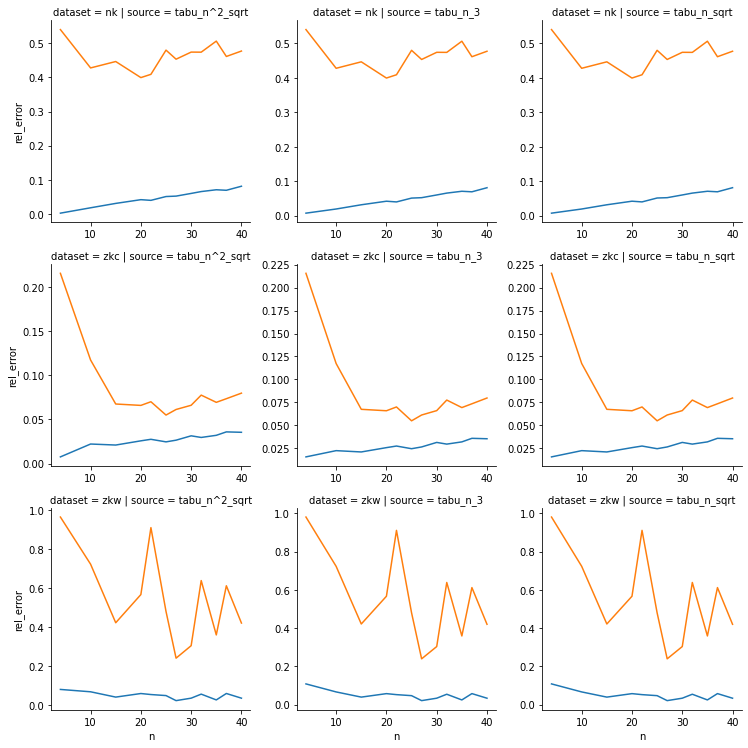

In [7]:
"""Visualize rel_error progress"""

# Create facetgrid datasets in columns, rel_error_type in rows
g = sns.FacetGrid(col="source", row="dataset", # hue='rel_error_type',
        data=aggregated_df[aggregated_df['source'] != aggregated_df['dataset']],
        sharey=False, sharex=False, height=3.5) # , hue="score"

# Visualize rel_error as barplot
# g.map(sns.barplot, 'n', 'rel_error', 'rel_error_type',
#         hue_order=['mean', 'max'], order=sorted(aggregated_df['n'].unique()),
#          palette=sns.color_palette())

# Visualize rel_error as lineplot
g.map(sns.lineplot, 'n', 'rel_error', 'rel_error_type')

In [8]:
%%time
"""
Create metadata dataframe

Wall time: 4.87 s
"""

metadata_df = None

# soln_path = "../tests/outs/nk_zkc_zkw/tabu_n_sqrt"
tabu_m_t_path = "../tests/outs/nk_zkc_zkw/tabu_n^2_sqrt"

for root, dirs, files in os.walk(tabu_m_t_path, topdown=False):
    for name in sorted(files):
        if ("meta" in name):
            if metadata_df is None:
                metadata_df = read_metadata_file(name, root)
            else:
                metadata_df = pd.concat([metadata_df, read_metadata_file(name, root)], ignore_index=True)

metadata_df.sample(n=5, random_state=SEED)

CPU times: user 4.23 s, sys: 901 ms, total: 5.13 s
Wall time: 5.32 s


dataset index   n   seconds         source step                     \
                                                    0    1      2      3   
6987      zkc   488  10  0.006405  tabu_n^2_sqrt -204  -13   6643   5995   
12413     zkw   838   4  0.000687  tabu_n^2_sqrt  -91  358    185      0   
10657     zkc   158  35  0.232760  tabu_n^2_sqrt -654 -419   -196  30501   
8046      zkc    47  22  0.062049  tabu_n^2_sqrt -253  -17  16456  16759   
1598       nk    99  20  0.035232  tabu_n^2_sqrt -462 -224  20074  19763   

              ...                                              total_eval  
           4  ... 1592 1593 1594 1595 1596 1597 1598 1599 1600             
6987    6655  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       1001  
12413    926  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN         65  
10657  29952  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      42876  
8046   16475  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      10649  
1598   19030  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       8001  

[5 rows x 1607 columns]

In [9]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13836 entries, 0 to 13835
Columns: 1607 entries, ('dataset', '') to ('total_eval', '')
dtypes: float64(1585), int64(20), object(2)
memory usage: 169.6+ MB


In [10]:
%%time
"""Dataframe for metadata visualizations"""

metadata_df = metadata_df.merge(opt_df, how='left', on=['dataset', 'n', 'index'])

meta_visu_df = pd.melt(
    metadata_df, id_vars=['dataset', 'index', 'n', 'seconds', 'source', 'total_eval', 'opt_value'],
    var_name=['drop_this', 'step']
).drop(['drop_this'], axis=1)

meta_visu_df

# meta_visu_df.fillna(0)

# sns.lineplot(x='step', y='value', hue='source', data=meta_visu_df)

/home/langerjaros/.langerenv_0.3/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


CPU times: user 2.95 s, sys: 810 ms, total: 3.76 s
Wall time: 3.76 s


,dataset,index,n,seconds,source,total_eval,opt_value,step,value
0,nk,1,4,0.001375,tabu_n^2_sqrt,65,1129,0,0.0
1,nk,2,4,0.001028,tabu_n^2_sqrt,65,2966,0,-99.0
2,nk,3,4,0.000880,tabu_n^2_sqrt,65,0,0,0.0
3,nk,4,4,0.000508,tabu_n^2_sqrt,65,70,0,-37.0
4,nk,5,4,0.000501,tabu_n^2_sqrt,65,2758,0,-215.0
...,...,...,...,...,...,...,...,...,...
23456246,zkw,1729,40,0.340148,tabu_n^2_sqrt,64001,5048,1600,4527.0
23456247,zkw,1846,40,0.361048,tabu_n^2_sqrt,64001,7956,1600,6646.0
23456248,zkw,1935,40,0.341812,tabu_n^2_sqrt,64001,7609,1600,3265.0
23456249,zkw,1987,40,0.363402,tabu_n^2_sqrt,64001,8712,1600,4684.0


In [11]:
%%time
"""
Compute rel_error for every metadata step

secs = ((0.920/100000) * 23456251); (secs//60, secs%60) # (3.0, 35.79750920000001)
Wall time: 4min 18s
"""

meta_visu_df['rel_error'] = meta_visu_df[['opt_value', 'value']].apply(lambda x: 
    calculate_rel_error(x[0], x[-1]), axis=1)


CPU times: user 4min 20s, sys: 6.03 s, total: 4min 26s
Wall time: 4min 41s


In [12]:
meta_visu_df

,dataset,index,n,seconds,source,total_eval,opt_value,step,value,rel_error
0,nk,1,4,0.001375,tabu_n^2_sqrt,65,1129,0,0.0,1.000000
1,nk,2,4,0.001028,tabu_n^2_sqrt,65,2966,0,-99.0,1.033378
2,nk,3,4,0.000880,tabu_n^2_sqrt,65,0,0,0.0,0.000000
3,nk,4,4,0.000508,tabu_n^2_sqrt,65,70,0,-37.0,1.528571
4,nk,5,4,0.000501,tabu_n^2_sqrt,65,2758,0,-215.0,1.077955
...,...,...,...,...,...,...,...,...,...,...
23456246,zkw,1729,40,0.340148,tabu_n^2_sqrt,64001,5048,1600,4527.0,0.103209
23456247,zkw,1846,40,0.361048,tabu_n^2_sqrt,64001,7956,1600,6646.0,0.164656
23456248,zkw,1935,40,0.341812,tabu_n^2_sqrt,64001,7609,1600,3265.0,0.570903
23456249,zkw,1987,40,0.363402,tabu_n^2_sqrt,64001,8712,1600,4684.0,0.462351


CPU times: user 17min 15s, sys: 7.61 s, total: 17min 22s
Wall time: 17min 34s


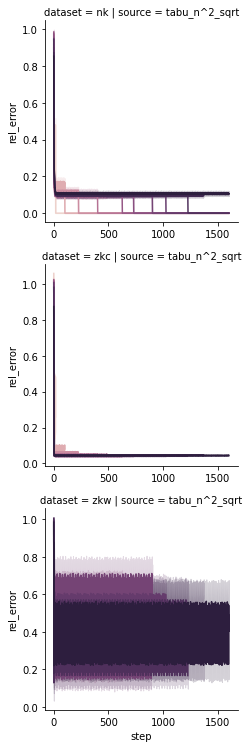

In [13]:
%%time
"""
Metadata visualization

secs=((60+1)/1000000)*23456251; (secs//60, secs%60) # (23.0, 50.831310999999914)
Wall time: 17min 34s
"""

# Create facetgrid datasets in columns, rel_error_type in rows
g = sns.FacetGrid(col="source", row="dataset", data=meta_visu_df, sharey=False, sharex=False, height=3.5) # , hue="score"

# Visualize rel_error as lineplot
g.map(sns.lineplot, 'step', 'rel_error', 'n') # 'rel_error_type'